# Long Short Time Memory Layer at EEG and BOLD embeddings

## Add an LSTM to add time series concept

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from iterative_naive_nas import Neural_Architecture

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt


#50_partitions
#optimized_parameters = [8.50071696e-04, 3.55273289e-01, 3.86577994e-01, 9.51559796e-01,
# 1.00000000e+00, 1.60000000e+01, 1.57000000e+03]
#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
activation=''

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'

/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/anacond

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 874, 14)
Extracting parameters from /home/davidcalhas/eeg

In [2]:
n_ica_components = 20

eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, f_resample=f_resample,
                                                                roi=1, roi_ica_components=n_ica_components)

n_voxels = bold_train.shape[1]

#standardize data
eeg_train, bold_train, eeg_scaler, bold_scaler = data_utils.standardize(eeg_train, bold_train)
eeg_val, bold_val, _, _ = data_utils.standardize(eeg_val, bold_val, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)


n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

print("Finished Loading Data")

X_train_eeg, X_train_bold, tr_y, X_bold_train_target = data_utils.create_eeg_bold_pairs(eeg_train, bold_train, instances_per_individual=n_partitions)
X_val_eeg, X_val_bold, tv_y, X_bold_val_target = data_utils.create_eeg_bold_pairs(eeg_val, bold_val, instances_per_individual=n_partitions)

tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=1, roi_ica_components=n_ica_components)

eeg_test, bold_test, _, _ = data_utils.standardize(eeg_test, bold_test, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 2607, 14)
Extracting parameters from /home/davidcalhas

### Load and mutate the network 

In [5]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

#print(eeg_network.summary())
#print(bold_network.summary())

if(bold_input_shape[0] != bold_network.input_shape[1]):
    mid_shape = (720, 14, 1)

    nas = iterative_naive_nas.Iterative_Naive_NAS()
    nn = Neural_Architecture(layers=[nas.build_layer_Conv2D], output_shapes=[], real_output_shapes=[])

    bold_network = nn.build_net(bold_input_shape, mid_shape, verbose=True)

    nas = iterative_naive_nas.Iterative_Naive_NAS()
    nn = Neural_Architecture(layers=[nas.build_layer_Conv2DTranspose], output_shapes=[], real_output_shapes=[])

    decoder_network = nn.build_net(mid_shape, bold_input_shape, verbose=True)


multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, lstm=True, dcca=False)

### Train Network

In [6]:
validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            loss_function=losses.get_reconstruction_log_cosine_voxel_loss,
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y,
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_bold_train_target=X_bold_train_target,
                                                            X_bold_val_target=X_bold_val_target)

model_name = "LComb"

Encoder Loss:  0.2543273  || Decoder Loss:  -0.34498644 Validation Decoder Loss:  -0.90177554
Encoder Loss:  0.26572475  || Decoder Loss:  -0.38435534 Validation Decoder Loss:  -0.97696036
Encoder Loss:  0.33853248  || Decoder Loss:  -0.44703233 Validation Decoder Loss:  -1.0747472
Encoder Loss:  0.39447844  || Decoder Loss:  -0.5250258 Validation Decoder Loss:  -1.3525287
Encoder Loss:  0.4156784  || Decoder Loss:  -0.5943487 Validation Decoder Loss:  -1.4281595
Encoder Loss:  0.41725874  || Decoder Loss:  -0.6160403 Validation Decoder Loss:  -1.5313333
Encoder Loss:  0.44669586  || Decoder Loss:  -0.66545373 Validation Decoder Loss:  -1.6893375
Encoder Loss:  0.46091586  || Decoder Loss:  -0.70408493 Validation Decoder Loss:  -1.8167392
Encoder Loss:  0.6196474  || Decoder Loss:  -0.9627098 Validation Decoder Loss:  -4.664501
Encoder Loss:  0.74827856  || Decoder Loss:  -1.1985136 Validation Decoder Loss:  -5.922074
Encoder Loss:  0.7517243  || Decoder Loss:  -1.2071532 Validation De

KeyboardInterrupt: 

train set mean:  -0.30366273267148064
train set std:  0.2877454484618557
validation set mean:  -1.4494138979911804
validation set std:  0.016999611248426857
test set mean:  -1.4677752768993377
test set std:  0.028950495319419664


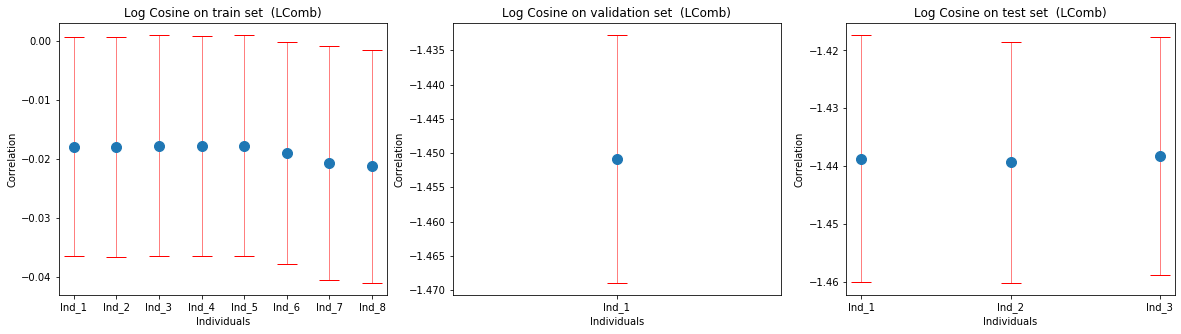

train set mean:  -2.445613917350769
train set std:  0.1502956239511265
validation set mean:  -6.67387288570404
validation set std:  0.8897774938363006
test set mean:  -6.598048038482666
test set std:  0.8149111017551752


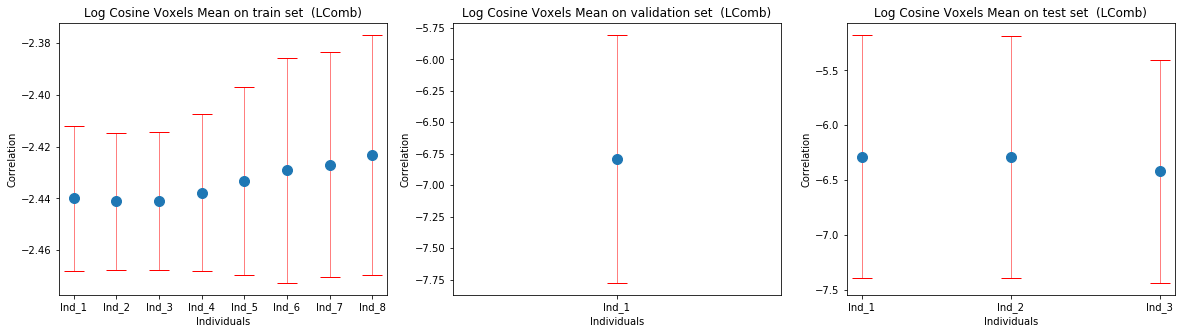

train set mean:  0.2336834431500174
train set std:  0.19096035206698178
validation set mean:  0.7652582263946534
validation set std:  0.004000160094613841
test set mean:  0.7694655203819275
test set std:  0.006707351670409213


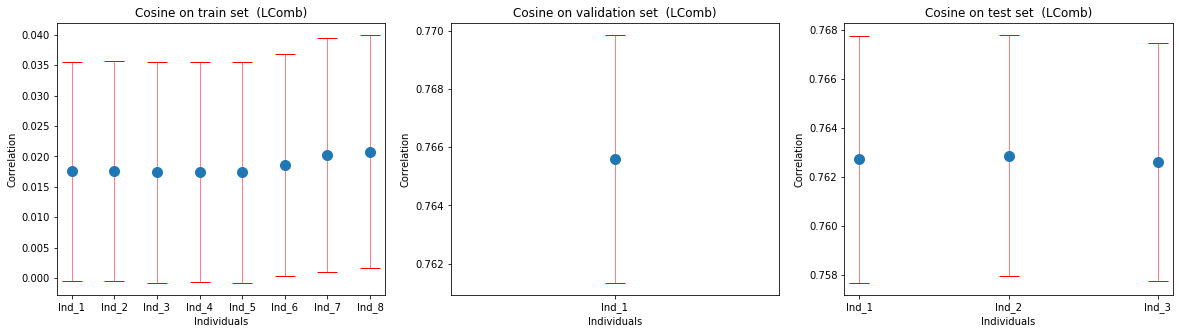

train set mean:  0.9123905718326568
train set std:  0.012268035657771043
validation set mean:  0.9977343785762787
validation set std:  0.004519702671896741
test set mean:  0.9977692991495133
test set std:  0.0037378081146064155


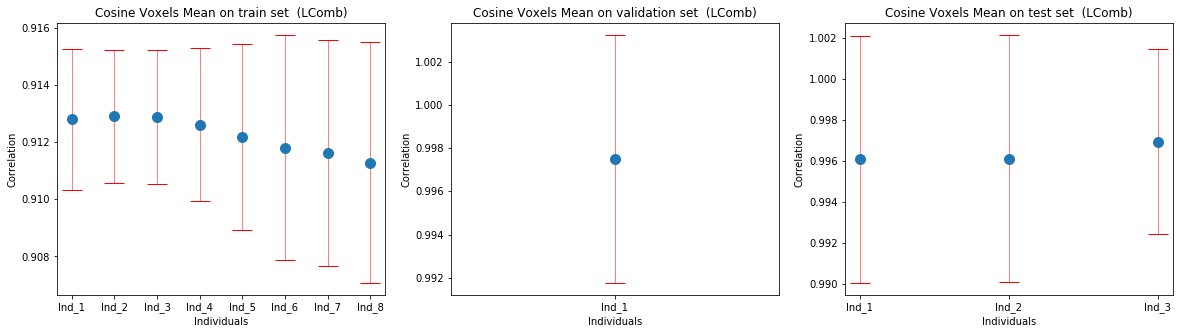

train set mean:  3223.5472783203127
train set std:  200.77105681856654
validation set mean:  4727.29841796875
validation set std:  112.28239497485036
test set mean:  4853.564116210938
test set std:  182.5480555313611


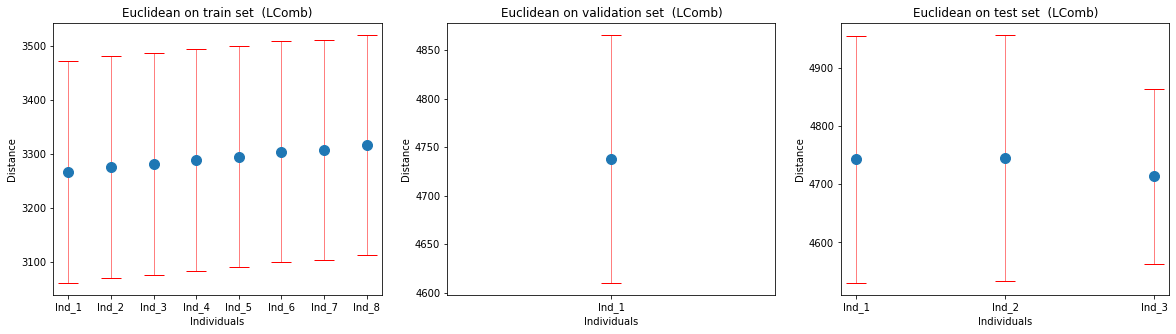

In [7]:
model_name="LComb"


viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

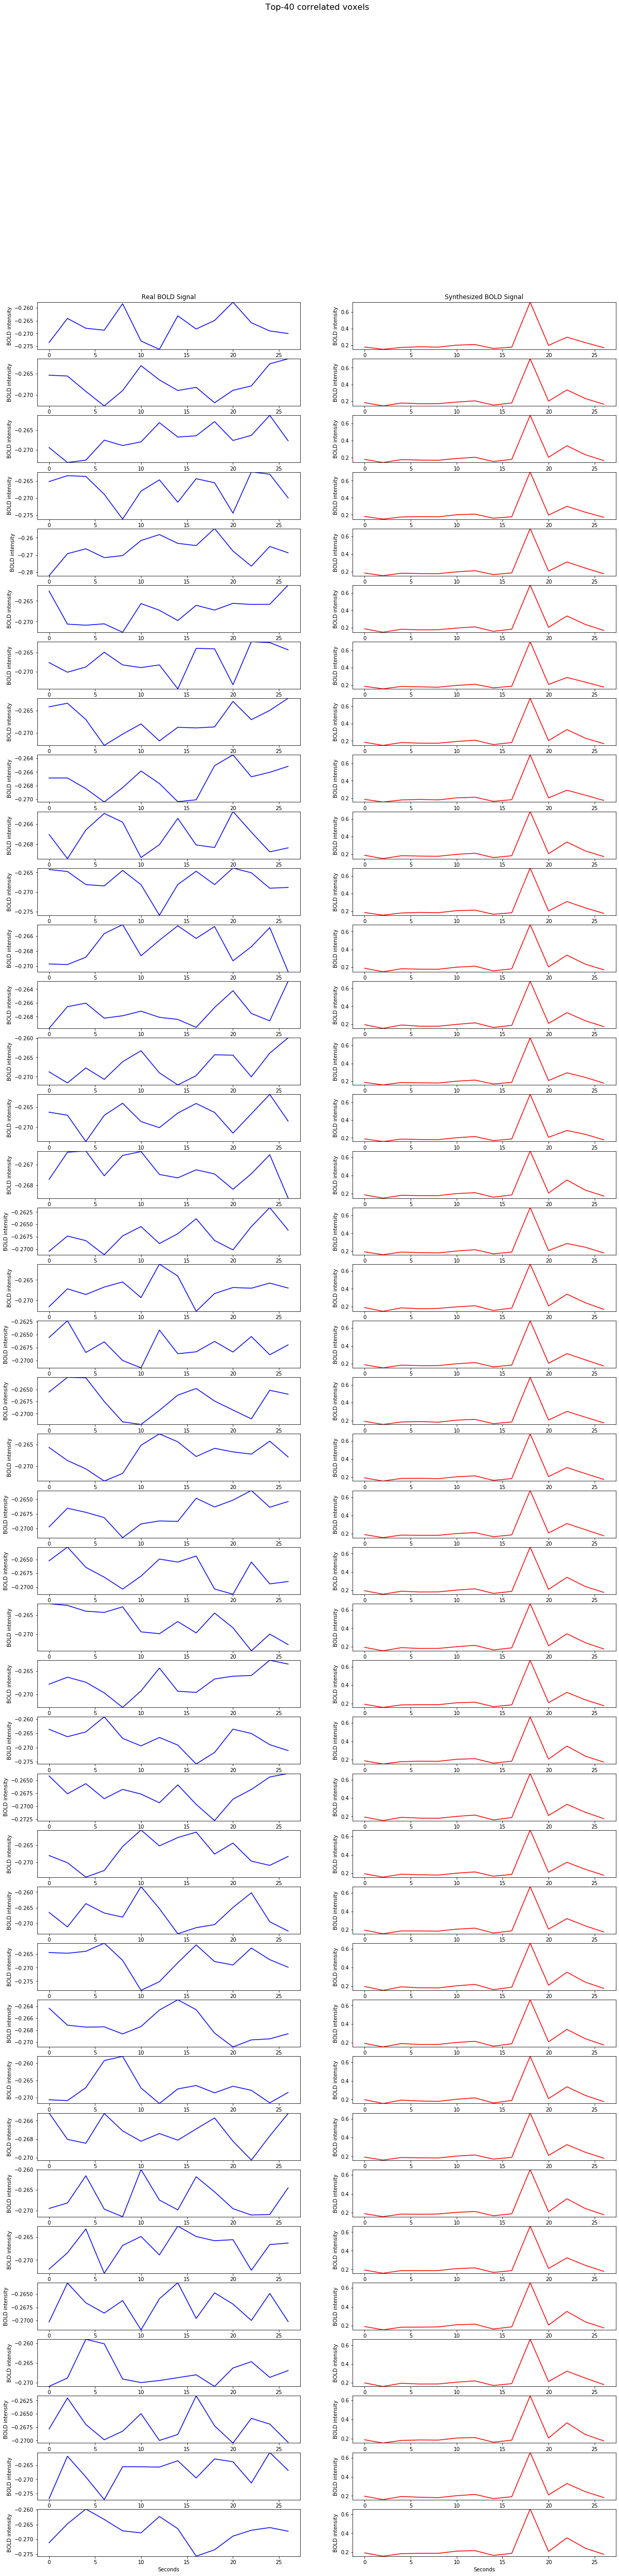

In [10]:
eeg_set = eeg_val
bold_set = bold_val

top_k = 40

#top_voxels = rank_best_synthesized_voxels(bold_set[individual], decoder_network(eeg_network(eeg_set))[individual].numpy(), top_k=top_k)

global_shape = (bold_set.shape[0]*bold_set.shape[1], bold_set.shape[2], bold_set.shape[3])
individual = None
top_voxels = viz.rank_best_synthesized_voxels(bold_set.reshape(global_shape), decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape), top_k=top_k)

viz._plot_voxels(bold_set.reshape(global_shape), decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape),
             individual=individual, voxels=top_voxels, normalized=True)
